In [573]:
#Imports and Settings
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from operator import mul
import seaborn as sn
import random

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler

#Helper Functions
from helper import predict, confusion_matrix1, calculate_threshold_values, plot_roc
#Pandas Settings to Display Rows and Cols
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

#Matplotlib Style Settings
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

#Pandas Standaridzer for Float Formatting
#pd.options.display.float_format = '{:,.2f}'.format
#pd.reset_option('display.float_format')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

In [2]:
# Looping through data folder to concat CSV's into one big dataframe
# 1002400 rows in dataset
# 63 columns
# Reinitialize HERE

for i,name in tqdm(enumerate(glob.glob('data/CSV/*'))):
    if i == 0:
        df = pd.read_csv(name)
    df2 = pd.read_csv(name)
    concat = pd.concat([df,df2],ignore_index=True)
    df = concat

In [3]:
#Back Up Reinitilization 
data = df.copy()

In [4]:
# Reinitilize DF
%time df = data.copy()

CPU times: user 334 ms, sys: 321 ms, total: 655 ms
Wall time: 652 ms


In [5]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011268 entries, 0 to 1011267
Data columns (total 63 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   M                    1011266 non-null  object 
 1   LA_No                1011252 non-null  object 
 2   T_No                 1011268 non-null  object 
 3   Classics_Request_ID  16 non-null       object 
 4   End_Of_Run           1011268 non-null  object 
 5   Start_Date           1011268 non-null  object 
 6   First_Date           1011268 non-null  object 
 7   Last_Date            1011268 non-null  object 
 8   Play_Dates           1011224 non-null  object 
 9   FRM                  1011268 non-null  object 
 10  Release              1011268 non-null  object 
 11  Local                1011252 non-null  float64
 12  Media_Formats        1010597 non-null  object 
 13  Rental_Measure       1011268 non-null  object 
 14  Theatre              1011268 non-null  object 
 15

In [6]:
data.head(1)

,M,LA_No,T_No,Classics_Request_ID,End_Of_Run,Start_Date,First_Date,Last_Date,Play_Dates,FRM,Release,Local,Media_Formats,Rental_Measure,Theatre,Status,Boxoffice,Boxoffice_Net,Film_Rental,To_Receive,Admissions,FRM_Perc,Terms_Perc,Price,Min_Max,MG_FF,Office,Customer_Reference,Film_Buyer,Buying_Circuit,Payer,Remark,Payer_Remark,DType,Aspect_Ratio,Sound_System,Seat_Type,Amenity,Frame_Rate,Resolution,Projection_Type,Licensor,L,Hire,Rem_,Rem_Date,Show,Media_Type,Dim_,LV,Division,Branch,TV_Market,Area,Circuit,City,Seeks_Run,No,Usage,VPF_Company,Sales,Screen,NENR
0,-,00081065-01,1,NaN,n,3/16/2018 00:00:00,3/16/2018 00:00:00,3/18/2018 00:00:00,03/16;03/17;03/18,ff,"LEGO NINJAGO MOVIE, THE",2066081.0,ENG.2.DIG.0.0.0.0,none,MARCUS ST. CLAIR 10,Approved,0.0,0.0,175.0,175.0,0,0.0,-,0,-,175.0,ENCINO OFFICE,NaN,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,NaN,NaN,no,no,no,none,none,none,none,none,None,NaN,0.0,0.0,1/1/1950 00:00:00,Normal,no,-,non,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO",MARCUS THEATRES,"FAIRVIEW HEIGHTS, IL",OTHER - Temp Close,( 1 ),1.0,Cinedigm 2,sgoyette,MARCUS ST. CLAIR 10,NaN


In [7]:
#Trimming off extraneous columns
df = df.iloc[:,1:57]
df = df.drop(['Classics_Request_ID','End_Of_Run','Play_Dates','Start_Date','Local','Rental_Measure','Boxoffice_Net',
              'Film_Rental','To_Receive','FRM_Perc','Min_Max','MG_FF','Price','Customer_Reference','Office',
             'Remark','Payer_Remark','DType','Aspect_Ratio','Sound_System','Seat_Type','Amenity','Frame_Rate',
             'Resolution','Projection_Type','Licensor','L','Hire','Rem_','Rem_Date','Media_Type','Dim_','LV','Circuit'],axis=1)
#Data Leakage
#df = df.drop('Admissions',axis=1)
df.head(2)

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
0,00081065-01,1,3/16/2018 00:00:00,3/18/2018 00:00:00,ff,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,MARCUS ST. CLAIR 10,Approved,0.0,0,-,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,Normal,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO","FAIRVIEW HEIGHTS, IL",OTHER - Temp Close
1,00085822-14,14,2/24/2018 00:00:00,2/24/2018 00:00:00,sp,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,KINGSWAY 2,Returns In,0.0,0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE - Temp Close


In [8]:
#Drop any duplicate ID's
df.drop_duplicates('LA_No',inplace=True)

#Dropping any non SP payments
df = df[df['FRM']=='sp'] 

# Only looking at records with grosses returned
df = df[df['Status']=='Returns In']

df = df[df.Division != 'CLASSICS']

#Dropping 500 NAN media formats
df = df.dropna(axis=0)

#Not in YT Data
df = df[df.Release !='THEY SHALL NOT GROW OLD']
df = df[df.Release !='FANTASTIC BEASTS AND WHERE TO FIND THEM']

In [9]:
df['First_Date'] = pd.to_datetime(df['First_Date'])
df['Last_Date'] = pd.to_datetime(df['Last_Date'])

df['Boxoffice'] = df['Boxoffice'].astype(str)
df['Boxoffice'] = df['Boxoffice'].apply(lambda x: x.replace(',', ''))
df['Boxoffice'] = df['Boxoffice'].astype(float)
df['T_No'] = df['T_No'].astype(float)

# Removed Admissions because of data leakage
df['Admissions'] = df['Admissions'].astype(str)
df['Admissions'] = df['Admissions'].apply(lambda x: x.replace(',', ''))
df['Admissions'] = df['Admissions'].astype(float)


In [10]:
def format_assign(x):
    if 'IMAX' in x or 'IXD'in x or 'DIMX' in x:     
        return 'IMAX'
    if 'PLF' in x or 'PLD' in x:
        return 'PLF'
    elif '3D' in x:
        return '3D'
    else:
        return '2D'

def seeks_run(x):
    if 'FIRST' in x:
        return 'FIRST RUN'
    elif 'LATE' in x:
        return 'LATE RUN'
    elif 'SUB' in x:
        return 'SUB RUN'
    else:
        return 'OTHER'
    # Intermediate Run, Other-Temp Close, IMAX, Art House, Calendar, Classics

df['Media_Formats'] = df['Media_Formats'].astype(str)
df['Media_Formats'] = df['Media_Formats'].swifter.apply(format_assign)
df['Seeks_Run'] = df['Seeks_Run'].swifter.apply(seeks_run)

In [11]:
df.groupby('Media_Formats').sum('Boxoffice')

,T_No,Boxoffice,Admissions
Media_Formats,,,
2D,3090885.0,3.704911e+09,429390821.0
3D,23482.0,2.012524e+08,19477106.0
IMAX,46714.0,4.654207e+08,38599556.0
PLF,68489.0,6.295114e+08,59220404.0


In [12]:
df.groupby('Seeks_Run').sum('Boxoffice')

,T_No,Boxoffice,Admissions
Seeks_Run,,,
FIRST RUN,3083809.0,4.925436e+09,531240960.0
LATE RUN,69372.0,4.259283e+07,7204845.0
OTHER,45927.0,2.402479e+07,4435732.0
SUB RUN,30462.0,9.041524e+06,3806350.0


In [13]:
df.head(1)

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
1,00085822-14,14.0,2018-02-24,2018-02-24,sp,"LEGO NINJAGO MOVIE, THE",2D,KINGSWAY 2,Returns In,0.0,0.0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE RUN


# Anonymizing Data

In [14]:
from faker import Faker

In [15]:
# Number of values to annoymize
# 6022 Theatres
# 4661 Film Buyer/Buying Circuit/Payer
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['Theatre','Film_Buyer','Buying_Circuit','Payer']].nunique())

Theatre           6001
Film_Buyer        1044
Buying_Circuit     795
Payer             2789
dtype: int64


In [16]:
confid_users = list(df.Payer.unique())
confid_users.extend(list(df.Buying_Circuit.unique()))
confid_users.extend(list(df.Film_Buyer.unique()))

In [17]:
len(confid_users)

4628

In [18]:
distinct_confid = set(confid_users)

In [19]:
Faker.seed(2)
fake = Faker()
fake_names = []
for _ in tqdm(range(5300)):
    fake_names.append(fake.company())
fake_names = set(fake_names)
fake_names = list(fake_names)

In [20]:
confid_dict = dict.fromkeys(distinct_confid)
for key,value in tqdm(confid_dict.items()):
    confid_dict[key] = random.sample(fake_names,1)[0]

In [21]:
cinema_names = pd.read_csv('data/extra_data/Cinema_names.csv',header=None)

In [22]:
cinema_names

,0
0,Cinema Editor
1,Cinemaops
2,Cinema Bravo
3,Cinemagenix
4,Cinema Tenacious
...,...
669,Cinema Own
670,Cinema Rah
671,Cinema Our
672,Cinema Project


In [23]:
cinema_list = []
for n in tqdm(range(0,674)):
    if len(cinema_names[0].apply(lambda x: x.split(' '))[n])>1:
        cinema_list.append(cinema_names[0].apply(lambda x: x.split(' '))[n][1])
    else:
        continue

In [24]:
suffixes = ['Theaters','Cinemas','Movies','Flicks','Screens','Forum']
maccs_theatres = df['Theatre'].unique().tolist()
maccs_theatres_dict = dict.fromkeys(maccs_theatres)

In [25]:
for key,value in maccs_theatres_dict.items():
    maccs_theatres_dict[key] = random.choice(cinema_list) +' '+ random.choice(cinema_list) + ' '+ random.choice(suffixes) 

maccs_theatres_dict

{'KINGSWAY 2': 'Arrowhead Guardian Flicks',
 'CANYON MEADOWS 10': 'Explosion Fans Cinemas',
 'RAINBOW 8 ': 'Awards Bevy Screens',
 'MARCUS SHOWTIME 12': 'Essential Dynamic Theaters',
 'BLUE RIDGE 14': 'Major Stargazer Forum',
 'CINEMARK MOVIES 16': 'Details Inspire Screens',
 'PICTURE SHOW 8': 'Wise Buster Screens',
 'WESTWOOD CINEMA 8': 'Own Rainbow Cinemas',
 'MARCUS ST. CLAIR 10': 'Mungo Bam Forum',
 'MOVIES 10': 'Enjoy Den Screens',
 'MASTERS 7': 'Muno Panel Theaters',
 'HOLLYWOOD USA 15': 'Pico Indy Screens',
 'NASA 8': 'Macro Vortex Forum',
 'SUPER SAVER CINEMAS 6': 'Neon Fuze Forum',
 'PICTURE SHOW 8 @ SUPERSTITION SPRINGS': 'Push Perfect Forum',
 'PALACE W CINEMA 8': 'Lime Force Forum',
 'MOVIES 12': 'Cerberus Effective Screens',
 'MOVIES 9': 'Assembly Blink Flicks',
 'COTTONWOOD 4': 'Azure Pro Flicks',
 'HOLLYWOOD SURREY 3': 'Ment Own Cinemas',
 'W BOYLSTON CINEMA 5': 'Myst Hype Movies',
 'PICTURE SHOW 6': 'Mammoth Core Forum',
 'COVENTRY 13': 'Move Points Movies',
 'RIVERVIEW

In [26]:
%time df['Theatre'].replace(maccs_theatres_dict,inplace=True)
%time df['Buying_Circuit'].replace(confid_dict,inplace=True)
%time df['Film_Buyer'].replace(confid_dict,inplace=True)
%time df['Payer'].replace(confid_dict,inplace=True)

CPU times: user 2min 42s, sys: 3.17 s, total: 2min 45s
Wall time: 2min 45s
CPU times: user 1min 7s, sys: 2.15 s, total: 1min 9s
Wall time: 1min 9s
CPU times: user 1min 8s, sys: 1.94 s, total: 1min 10s
Wall time: 1min 10s
CPU times: user 1min 12s, sys: 2.05 s, total: 1min 14s
Wall time: 1min 14s


In [ ]:
test = df.query("Theatre=='Justice Dollar Movies' & action == 1.00 ").groupby('Release').agg({'Boxoffice':'sum','Admissions':'sum','T_No':'max'})
test

In [488]:
release_date = yt_views[yt_views.columns[:2]]
release_date['Release Date'] = pd.to_datetime(release_date['Release Date'])

In [529]:
len(release_date)

55

In [533]:
#Only opening week WITH RELEASE DATE
ow_test = df[df['T_No']==1].sort_values(['Theatre','Release','T_No'])
ow_test.reset_index(inplace=True)
ow_test.drop(['index','FRM','LA_No','Status','Last_Date','Terms_Perc','TV_Market','Area'],axis=1,inplace=True)
ow_test = ow_test.merge(release_date,left_on='Release',right_on='Film (Distributor)')
ow_test['open_week'] = ow_test['First_Date']-ow_test['Release Date']
ow_test['open_week'] = ow_test['open_week'].dt.days
ow_test['open_week'] = ow_test['open_week'].swifter.apply(lambda x: 1 if x <=1 else 0)
ow_test = ow_test[ow_test['open_week']==1]
ow_test['Release'].nunique()

52

In [527]:
len(ow_test['Release'].unique())

51

In [524]:
ow_test.groupby('Release')['T_No'].count()

Release
12 STRONG                        2972
15:17 TO PARIS, THE              3011
ANNABELLE COMES HOME             3475
ANNABELLE: CREATION              3467
AQUAMAN (2018)                   5393
                                 ... 
TAG (2018)                       3340
TEEN TITANS GO! TO THE MOVIES    3149
TOMB RAIDER                      3816
UNFORGETTABLE                    2391
WONDER WOMAN                     4127
Name: T_No, Length: 51, dtype: int64

In [506]:
#Only opening week
ow_df = df[df['Seeks_Run']=='FIRST RUN'].sort_values(['Theatre','Release','T_No'])
ow_df = ow_df[ow_df['T_No']==1]
ow_df.reset_index(inplace=True)
ow_df.drop(['index','FRM','LA_No','Status','First_Date','Last_Date','Terms_Perc','TV_Market','Area'],axis=1,inplace=True)


ow_df

,T_No,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run
0,1.0,12 STRONG,2D,About Boards Flicks,1737.00,261.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN
1,1.0,"15:17 TO PARIS, THE",2D,About Boards Flicks,1478.50,221.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN
2,1.0,ANNABELLE COMES HOME,2D,About Boards Flicks,2903.50,404.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN
3,1.0,ANNABELLE: CREATION,2D,About Boards Flicks,3348.50,454.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN
4,1.0,AQUAMAN (2018),2D,About Boards Flicks,8327.50,1196.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,TAG (2018),2D,for Scope Flicks,5053.50,673.0,Stafford Group,Davis-Russell,Davis-Russell,Normal,WESTERN,DES MOINES,"CEDAR FALLS, IA",FIRST RUN
205420,1.0,TEEN TITANS GO! TO THE MOVIES,2D,for Scope Flicks,2681.00,401.0,Stafford Group,Davis-Russell,Davis-Russell,Normal,WESTERN,DES MOINES,"CEDAR FALLS, IA",FIRST RUN
205421,1.0,TOMB RAIDER,2D,for Scope Flicks,3907.00,519.0,Stafford Group,Davis-Russell,Davis-Russell,Normal,WESTERN,DES MOINES,"CEDAR FALLS, IA",FIRST RUN
205422,1.0,UNFORGETTABLE,2D,for Scope Flicks,944.00,138.0,Stafford Group,Davis-Russell,Davis-Russell,Normal,WESTERN,DES MOINES,"CEDAR FALLS, IA",FIRST RUN


In [507]:
#Total Opening Week Numbers
#with pd.option_context('display.float_format','{:,.2f}'):
ow_bo = ow_df.groupby('Release').sum()['Boxoffice']
ow_bo = ow_bo.astype(int)
ow_bo = ow_bo.reset_index()
ow_bo['Boxoffice_Total'] = ow_bo['Boxoffice']
ow_bo.drop('Boxoffice',axis=1,inplace=True)

ow_bo

,Release,Boxoffice_Total
0,12 STRONG,19892950
1,"15:17 TO PARIS, THE",17744384
2,ANNABELLE COMES HOME,39301786
3,ANNABELLE: CREATION,45340847
4,AQUAMAN (2018),119892164
...,...,...
49,TAG (2018),22798241
50,TEEN TITANS GO! TO THE MOVIES,16205368
51,TOMB RAIDER,27926483
52,UNFORGETTABLE,6497468


In [509]:
ow_data = ow_df.merge(ow_bo,how='left',left_on='Release',right_on='Release')

In [510]:
ow_data['perc_of_bo'] = (ow_data.Boxoffice/ow_data.Boxoffice_Total).astype(float)
ow_data['perc_of_bo'] = round(ow_data['perc_of_bo'],5)

In [511]:
ow_data.head(1)

,T_No,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo
0,1.0,12 STRONG,2D,About Boards Flicks,1737.0,261.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,19892950,0.00009


# Baseline with average of entire data set, of all movies, all theatres, first 3 weeks

In [539]:

ow_data['over_index'] = ow_data['perc_of_bo']-ow_data.describe()['perc_of_bo'].loc['mean']
ow_data['over_index'] = ow_data['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_data = ow_data[ow_data['T_No']==1]
ow_data = ow_data[ow_data['Seeks_Run'] == 'FIRST RUN']
ow_data.head()


,T_No,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo,over_index
0,1.0,12 STRONG,2D,About Boards Flicks,1737.0,261.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,19892950,0.00009,0
1,1.0,"15:17 TO PARIS, THE",2D,About Boards Flicks,1478.5,221.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,17744384,0.00008,0
2,1.0,ANNABELLE COMES HOME,2D,About Boards Flicks,2903.5,404.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,39301786,0.00007,0
3,1.0,ANNABELLE: CREATION,2D,About Boards Flicks,3348.5,454.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,45340847,0.00007,0
4,1.0,AQUAMAN (2018),2D,About Boards Flicks,8327.5,1196.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,119892164,0.00007,0


In [540]:
ow_data['over_index'].value_counts()

0    131482
1     73942
Name: over_index, dtype: int64

In [541]:
ow_data.groupby('Release')['over_index'].value_counts()


Release               over_index
12 STRONG             0             1798
                      1             1496
15:17 TO PARIS, THE   0             1771
                      1             1526
ANNABELLE COMES HOME  0             2560
                                    ... 
TOMB RAIDER           1             1346
UNFORGETTABLE         1             1405
                      0             1061
WONDER WOMAN          0             3880
                      1             1350
Name: over_index, Length: 108, dtype: int64

# TMDb Movie Data

In [189]:
wb_list = df['Release'].unique().tolist()
wb_list

['LEGO NINJAGO MOVIE, THE',
 'TEEN TITANS GO! TO THE MOVIES',
 'IT (2017)',
 "ISN'T IT ROMANTIC",
 '15:17 TO PARIS, THE',
 'PADDINGTON 2',
 'SUN IS ALSO A STAR, THE',
 'KING ARTHUR: LEGEND OF THE SWORD',
 'EVERYTHING, EVERYTHING',
 'RAMPAGE (2018)',
 'LIFE OF THE PARTY',
 'JOKER',
 'SMALLFOOT',
 'READY PLAYER ONE',
 'IT CHAPTER TWO',
 'JUSTICE LEAGUE (2017)',
 'CHIPS (2017)',
 'TAG (2018)',
 'CRAZY RICH ASIANS',
 'HOUSE, THE (2017)',
 'SHAZAM! (2019)',
 'NUN, THE',
 '12 STRONG',
 'SHAFT (2074539)',
 'DUNKIRK (2017)',
 'RICHARD JEWELL',
 'DOCTOR SLEEP (2019)',
 'UNFORGETTABLE',
 'GAME NIGHT',
 'CURSE OF LA LLORONA, THE',
 'GOLDFINCH, THE',
 'STAR IS BORN, A (2024779)',
 'FATHER FIGURES',
 'TOMB RAIDER',
 'KITCHEN, THE',
 'MEG, THE',
 'FIST FIGHT',
 'LEGO BATMAN MOVIE, THE',
 'BLINDED BY THE LIGHT (2083623)',
 "OCEAN'S 8",
 'WONDER WOMAN',
 'POKEMON DETECTIVE PIKACHU',
 'MULE, THE',
 'GOOD LIAR, THE',
 'AQUAMAN (2018)',
 'LEGO MOVIE 2, THE: THE SECOND PART',
 'MOTHERLESS BROOKLYN',
 'GEO

In [ ]:
len(movies)

In [37]:
clean = []
for title in wb_list:
    save = title.split("(")
    clean.append(save[0])

In [ ]:
clean;

In [38]:
import difflib
import itertools
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [410]:
movie_data = pd.read_csv('data/extra_data/wb_df.csv')
movie_data = movie_data.drop(['Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
movie_data['month'] = movie_data['release_date'].dt.month
#movie_data['weeknum'] = movie_data['release_date'].dt.week


from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect_trans = vect.fit_transform(movie_data.genre_ids)
count_df = pd.DataFrame(data=vect_trans.todense(), columns=vect.get_feature_names())
#count_df.index += 1
movies = pd.merge(movie_data, count_df, left_index=True, right_index=True)
movies = movies.drop(['genre_ids','release_date','revenue'],axis=1)

#Matching between TMDb and WB
movies.at[9,'title'] = "HOUSE, THE"
movies.at[29,'title'] = "MEG, THE"
movies.at[31,'title'] = "NUN, THE"
movies.at[35,'title'] = "MULE, THE"
movies.at[44,'title'] = "SHAFT (2074539)"
movies = movies[movies.title !='They Shall Not Grow Old']
movies['title'] = movies['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
movies['title'] = movies['title'].apply(lambda x: x.replace("{'",''))
movies['title'] = movies['title'].apply(lambda x: x.replace("'}",''))
movies.at[12,'title'] = "IT (2017)"
movies.at[38,'title'] = "ISN'T IT ROMANTIC"
movies.at[27,'title'] = "OCEAN'S 8"

movies.at[32,'budget'] = 80000000
movies.at[42,'budget'] = 9000000
movies.at[47,'budget'] = 15000000

''' 
Action/Adventure
Family/Animation
Romance/Comedy
Drama
Crime/Thriller
Sci Fi/Fantasy
Horror
Other
'''

movies['act/adv'] = movies['action']+movies['adventure']
movies['act/adv'] = movies['act/adv'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['ani/fam'] = movies['animation']+movies['family']
movies['ani/fam'] = movies['ani/fam'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['rom/com'] = movies['romance']+movies['comedy']
movies['rom/com'] = movies['rom/com'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['crime_thriler'] = movies['crime']+movies['thriller']
movies['crime_thriler'] = movies['crime_thriler'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['sci-fi/fan'] = movies['science']+movies['fiction']+movies['fantasy']
movies['sci-fi/fan'] = movies['sci-fi/fan'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['old_war'] = movies['history']+movies['war']
movies['old_war'] = movies['old_war'].swifter.apply(lambda x: 1 if x>=1 else 0)

movies.drop(['action','adventure','animation','family','romance','comedy','crime','thriller','science','fiction','fantasy','history','war'],axis=1, inplace=True)
movies.head(1)

,title,overview,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war
0,CHIPS (2017),The adventures of two California Highway Patro...,25000000,100,1,0,0,0,0,0,1,0,1,1,0,0


In [398]:
with pd.option_context("display.max_rows", 1000):
    display(movies)

,title,overview,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war
0,CHIPS (2017),The adventures of two California Highway Patro...,25000000,100,1,0,0,0,0,0,1,0,1,1,0,0
1,"LEGO BATMAN MOVIE, THE",A cooler-than-ever Bruce Wayne must deal with ...,80000000,104,2,0,0,0,0,0,1,2,1,0,1,0
2,FIST FIGHT,"When one school teacher gets the other fired, ...",22000000,91,2,0,0,0,0,0,0,0,1,0,0,0
3,UNFORGETTABLE,"Julia moves in with her fiancé, David, but his...",12000000,100,3,0,1,0,0,0,0,0,0,1,0,0
4,KONG: SKULL ISLAND,Explore the mysterious and dangerous home of t...,185000000,118,3,0,0,0,0,0,2,0,0,0,1,0
5,GOING IN STYLE (2017),Desperate to pay the bills and come through fo...,25000000,96,4,0,0,0,0,0,0,0,1,1,0,0
6,KING ARTHUR: LEGEND OF THE SWORD,"When the child Arthur’s father is murdered, Vo...",175000000,126,5,0,1,0,0,0,1,0,0,0,1,0
7,"EVERYTHING, EVERYTHING",A teenager who's lived a sheltered life becaus...,10000000,96,5,0,1,0,0,0,0,0,1,0,0,0
8,WONDER WOMAN,An Amazon princess comes to the world of Man i...,149000000,141,5,0,0,0,0,0,2,0,0,0,1,0
9,"HOUSE, THE (2017)",When Scott and Kate Johansen’s daughter gets i...,40000000,88,6,0,0,0,0,0,0,0,1,0,0,0


In [515]:
mc = movies.copy()
mc = mc.set_index('title')
mc.drop('overview',axis=1,inplace=True)
mc

,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war
title,,,,,,,,,,,,,,
CHIPS (2017),25000000,100,1,0,0,0,0,0,1,0,1,1,0,0
"LEGO BATMAN MOVIE, THE",80000000,104,2,0,0,0,0,0,1,1,1,0,1,0
FIST FIGHT,22000000,91,2,0,0,0,0,0,0,0,1,0,0,0
UNFORGETTABLE,12000000,100,3,0,1,0,0,0,0,0,0,1,0,0
KONG: SKULL ISLAND,185000000,118,3,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JOKER,55000000,122,10,0,1,0,0,0,0,0,0,1,0,0
DOCTOR SLEEP (2019),45000000,152,10,0,1,1,0,0,0,0,0,1,1,0
MOTHERLESS BROOKLYN,26000000,145,10,0,1,0,0,0,0,0,0,1,0,0


# YT Views to OW

In [516]:
yt_views = pd.read_csv('data/extra_data/OW to YT - BoxOfficeReport - WB 2017-2019.csv')
yt_views['Release Date'] = pd.to_datetime(yt_views['Release Date'])
yt_views = yt_views[yt_views['Release Date']<'2020']
yt_views['Film (Distributor)'] =yt_views['Film (Distributor)'].apply(lambda x: x.split('(')[0])
yt_views['Film'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("{'",''))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("'}",''))

yt_views.at[25,'Film (Distributor)'] = "ISN'T IT ROMANTIC"
yt_views.at[37,'Film (Distributor)'] = "OCEAN'S 8"

yt_views = yt_views.reset_index()
yt_display = yt_views.copy()
yt_views.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views','Film'],axis=1,inplace=True)


with pd.option_context("display.max_rows", 1000):
#    yt_display.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views'],axis=1,inplace=True)
    display(yt_views)

,Film (Distributor),OW to YT
0,RICHARD JEWELL,0.522
1,"GOOD LIAR, THE",0.513
2,DOCTOR SLEEP (2019),0.758
3,MOTHERLESS BROOKLYN,0.512
4,JOKER,0.852
5,"GOLDFINCH, THE",0.246
6,IT CHAPTER TWO,1.355
7,BLINDED BY THE LIGHT (2083623),0.762
8,"KITCHEN, THE",0.470
9,ANNABELLE COMES HOME,0.823


In [517]:
ow_data.head(1)

,T_No,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,City,Seeks_Run,Boxoffice_Total,perc_of_bo,over_index
0,1.0,12 STRONG,2D,About Boards Flicks,1737.0,261.0,"Dominguez, Williamson and Davis",Rodriguez PLC,Rodriguez PLC,Normal,EASTERN,CLEVELAND,"BRUNSWICK, OH",FIRST RUN,19892950,0.00009,0


In [542]:
#SMALLER TEST SUBSET
test = ow_data.copy()
test.drop(columns=['Theatre','Boxoffice','Admissions','Film_Buyer','Buying_Circuit','Payer','Branch','City','Seeks_Run','Boxoffice_Total'],inplace=True)
test

,T_No,Release,Media_Formats,Show,Division,perc_of_bo,over_index
0,1.0,12 STRONG,2D,Normal,EASTERN,0.00009,0
1,1.0,"15:17 TO PARIS, THE",2D,Normal,EASTERN,0.00008,0
2,1.0,ANNABELLE COMES HOME,2D,Normal,EASTERN,0.00007,0
3,1.0,ANNABELLE: CREATION,2D,Normal,EASTERN,0.00007,0
4,1.0,AQUAMAN (2018),2D,Normal,EASTERN,0.00007,0
...,...,...,...,...,...,...,...
205419,1.0,TAG (2018),2D,Normal,WESTERN,0.00022,0
205420,1.0,TEEN TITANS GO! TO THE MOVIES,2D,Normal,WESTERN,0.00017,0
205421,1.0,TOMB RAIDER,2D,Normal,WESTERN,0.00014,0
205422,1.0,UNFORGETTABLE,2D,Normal,WESTERN,0.00015,0


In [543]:
test_1hot = pd.get_dummies(data=test,columns=['Media_Formats','Show','Division'],drop_first=True)

test_1hot

,T_No,Release,perc_of_bo,over_index,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN
0,1.0,12 STRONG,0.00009,0,0,0,0,1,0,0
1,1.0,"15:17 TO PARIS, THE",0.00008,0,0,0,0,1,0,0
2,1.0,ANNABELLE COMES HOME,0.00007,0,0,0,0,1,0,0
3,1.0,ANNABELLE: CREATION,0.00007,0,0,0,0,1,0,0
4,1.0,AQUAMAN (2018),0.00007,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
205419,1.0,TAG (2018),0.00022,0,0,0,0,0,0,1
205420,1.0,TEEN TITANS GO! TO THE MOVIES,0.00017,0,0,0,0,0,0,1
205421,1.0,TOMB RAIDER,0.00014,0,0,0,0,0,0,1
205422,1.0,UNFORGETTABLE,0.00015,0,0,0,0,0,0,1


In [430]:
full_movie = movies.merge(yt_views,how='inner',left_on='title',right_on='Film (Distributor)')
#full_movie['OW to YT'] = full_movie['OW to YT'].fillna(0)
full_movie.drop(['Film (Distributor)','overview'],axis=1,inplace=True)
full_movie.drop_duplicates('title',inplace=True)



with pd.option_context("display.max_rows", 1000):
    display(full_movie)

,title,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT
0,CHIPS (2017),25000000,100,1,0,0,0,0,0,1,0,1,1,0,0,1.091
1,"LEGO BATMAN MOVIE, THE",80000000,104,2,0,0,0,0,0,1,1,1,0,1,0,1.697
2,FIST FIGHT,22000000,91,2,0,0,0,0,0,0,0,1,0,0,0,1.361
3,UNFORGETTABLE,12000000,100,3,0,1,0,0,0,0,0,0,1,0,0,0.888
4,KONG: SKULL ISLAND,185000000,118,3,0,0,0,0,0,1,0,0,0,1,0,1.728
5,GOING IN STYLE (2017),25000000,96,4,0,0,0,0,0,0,0,1,1,0,0,4.511
6,KING ARTHUR: LEGEND OF THE SWORD,175000000,126,5,0,1,0,0,0,1,0,0,0,1,0,0.545
7,"EVERYTHING, EVERYTHING",10000000,96,5,0,1,0,0,0,0,0,1,0,0,0,2.113
8,WONDER WOMAN,149000000,141,5,0,0,0,0,0,1,0,0,0,1,0,1.226
9,DUNKIRK (2017),100000000,107,7,0,1,0,0,0,1,0,0,0,0,1,1.177


In [838]:
full_movie

,title,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT
0,CHIPS (2017),25000000,100,1,0,0,0,0,0,1,0,1,1,0,0,1.091
1,"LEGO BATMAN MOVIE, THE",80000000,104,2,0,0,0,0,0,1,1,1,0,1,0,1.697
2,FIST FIGHT,22000000,91,2,0,0,0,0,0,0,0,1,0,0,0,1.361
3,UNFORGETTABLE,12000000,100,3,0,1,0,0,0,0,0,0,1,0,0,0.888
4,KONG: SKULL ISLAND,185000000,118,3,0,0,0,0,0,1,0,0,0,1,0,1.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,JOKER,55000000,122,10,0,1,0,0,0,0,0,0,1,0,0,0.852
50,DOCTOR SLEEP (2019),45000000,152,10,0,1,1,0,0,0,0,0,1,1,0,0.758
51,MOTHERLESS BROOKLYN,26000000,145,10,0,1,0,0,0,0,0,0,1,0,0,0.512
52,"GOOD LIAR, THE",10000000,109,11,0,1,0,0,1,0,0,0,1,0,0,0.513


In [545]:
test_full = test_1hot.merge(full_movie,how='left',left_on='Release',right_on='title')
test_full.drop(columns=['Release','title','T_No','perc_of_bo'],inplace=True)
#test_full = test_full.fillna(0)
test_full

,over_index,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT
0,0,0,0,0,1,0,0,35000000.0,130.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.935
1,0,0,0,0,1,0,0,30000000.0,94.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.583
2,0,0,0,0,1,0,0,30000000.0,106.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.823
3,0,0,0,0,1,0,0,15000000.0,109.0,8.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.786
4,0,0,0,0,1,0,0,160000000.0,143.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,0,0,0,0,0,0,1,28000000.0,100.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.017
205420,0,0,0,0,0,0,1,10000000.0,85.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.665
205421,0,0,0,0,0,0,1,94000000.0,118.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.250
205422,0,0,0,0,0,0,1,12000000.0,100.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.888



## Combined with Movie Meta Data

In [103]:
def plot_corr(df):
    corr = df.corr()
    sn.heatmap(corr,annot=True,cmap='coolwarm',alpha=0.8)
    plt.title('Correlation Matrix')
    plt.show

In [415]:
#One Hot Encoded Theatre information, 5993x2773

theatre_df = df.groupby('Theatre')[df.columns[-9:]].first()
theatre_df.drop(['Show','Branch','Area','City'],axis=1, inplace=True)
theatre_df = pd.get_dummies(data=theatre_df,columns=['Buying_Circuit','Payer','Division','TV_Market','Seeks_Run'],drop_first=True)
theatre_df.head(1)

Buying_Circuit_Adams, Sampson and Monroe  Buying_Circuit_Adams-Baker  Buying_Circuit_Adkins LLC  Buying_Circuit_Alexander LLC  Buying_Circuit_Alexander-Benjamin  Buying_Circuit_Alexander-Hughes  Buying_Circuit_Allen, Wilson and Day  Buying_Circuit_Alvarado-Johnson  Buying_Circuit_Alvarez, Jimenez and Garrett  Buying_Circuit_Alvarez-Gomez  Buying_Circuit_Anderson, French and Wright  Buying_Circuit_Anderson, Norris and Dawson  Buying_Circuit_Anderson-Hess  Buying_Circuit_Andrade Group  Buying_Circuit_Andrade Ltd  Buying_Circuit_Andrews Group  Buying_Circuit_Austin, Brewer and Ayers  Buying_Circuit_Avila-Kelley  Buying_Circuit_Bailey-Hardy  Buying_Circuit_Baker Group  Buying_Circuit_Baker, Chavez and Taylor  Buying_Circuit_Baker, Harris and Avery  Buying_Circuit_Baldwin Inc  Buying_Circuit_Barnes and Sons  Buying_Circuit_Barnes-Ray  Buying_Circuit_Barnes-Wagner  Buying_Circuit_Barnett-West  Buying_Circuit_Barr, Lopez and Lopez  Buying_Circuit_Barton, Henry and Giles  Buying_Circuit_Beck-Smith  Buying_Circuit_Bell, Alvarado and Gonzalez  Buying_Circuit_Bell, Gordon and Martinez  Buying_Circuit_Bell-Swanson  Buying_Circuit_Beltran-Randall  Buying_Circuit_Bender-Garcia  Buying_Circuit_Benjamin, Wilson and Harper  Buying_Circuit_Bennett, Vargas and Frazier  Buying_Circuit_Bennett-Carrillo  Buying_Circuit_Benson, Morris and Smith  Buying_Circuit_Bernard Group  Buying_Circuit_Berry, Anderson and Hodge  Buying_Circuit_Bishop Ltd  Buying_Circuit_Black Inc  Buying_Circuit_Booth Inc  Buying_Circuit_Boyer Inc  Buying_Circuit_Bradley Inc  Buying_Circuit_Bradshaw, Callahan and Smith  Buying_Circuit_Brady Group  Buying_Circuit_Bray, Taylor and Brown  Buying_Circuit_Brennan PLC  Buying_Circuit_Briggs and Sons  Buying_Circuit_Brooks Inc  Buying_Circuit_Brooks LLC  Buying_Circuit_Brown, Fisher and Caldwell  Buying_Circuit_Brown, Haney and Wolfe  Buying_Circuit_Brown, Hernandez and Webb  Buying_Circuit_Brown, Walker and Irwin  Buying_Circuit_Brown-Perez  Buying_Circuit_Browning-Bailey  Buying_Circuit_Bruce, Hendricks and Briggs  Buying_Circuit_Bryan Ltd  Buying_Circuit_Bryan-Evans  Buying_Circuit_Bryant-Stewart  Buying_Circuit_Burgess-Byrd  Buying_Circuit_Burns Inc  Buying_Circuit_Burns-Howard  Buying_Circuit_Butler Group  Buying_Circuit_Butler, Erickson and Patel  Buying_Circuit_Butler, Newman and Franklin  Buying_Circuit_Butler-Carroll  Buying_Circuit_Cabrera, Wright and Patterson  Buying_Circuit_Campbell, Rivers and Brandt  Buying_Circuit_Campbell, Wells and Todd  Buying_Circuit_Cannon Ltd  Buying_Circuit_Carey Ltd  Buying_Circuit_Carlson, Watson and Snyder  Buying_Circuit_Carlson-Charles  Buying_Circuit_Carrillo-Valentine  Buying_Circuit_Carson, Cox and Brooks  Buying_Circuit_Carson-Sparks  Buying_Circuit_Case-Holmes  Buying_Circuit_Castro and Sons  Buying_Circuit_Chambers, Cantrell and Weaver  Buying_Circuit_Chandler, Johnson and Wright  Buying_Circuit_Chase, Pratt and Sampson  Buying_Circuit_Chase-Michael  Buying_Circuit_Chase-Perez  Buying_Circuit_Chase-Williams  Buying_Circuit_Chavez-Smith  Buying_Circuit_Chen Ltd  Buying_Circuit_Church-Black  Buying_Circuit_Clark Ltd  Buying_Circuit_Clark, Butler and Martinez  Buying_Circuit_Clark, Williams and Barnes  Buying_Circuit_Clark-Turner  Buying_Circuit_Coffey-Crawford  Buying_Circuit_Cohen Group  Buying_Circuit_Cohen and Sons  Buying_Circuit_Cole, Medina and Schultz  Buying_Circuit_Cole-Smith  Buying_Circuit_Coleman-Gomez  Buying_Circuit_Collier, Guerrero and Campbell  Buying_Circuit_Collins-Snyder  Buying_Circuit_Conley, Cunningham and Lyons  Buying_Circuit_Conrad PLC  Buying_Circuit_Cook, Castillo and Alexander  Buying_Circuit_Cooper Group  Buying_Circuit_Cooper Inc  Buying_Circuit_Cooper PLC  Buying_Circuit_Copeland and Sons  Buying_Circuit_Cordova-Moss  Buying_Circuit_Cruz, Smith and Johnson  Buying_Circuit_Cummings, Reeves and Young  Buying_Circuit_Cummings-Nelson  Buying_Circuit_Dalton Group  Buying_Circuit_Daniel Ltd  Buying_Circuit_Daniels, Patel and Sutton  Buying_Circuit_Davidson Inc  

In [419]:
movie_corr = test_full.copy()
movie_corr = movie_corr.drop(movie_corr.columns[1:7],axis=1)
movie_corr.corr()['over_index'].sort_values(ascending=False)

over_index       1.000000
crime_thriler    0.081230
drama            0.061771
old_war          0.036296
mystery          0.017125
                   ...   
runtime         -0.070943
music           -0.075200
sci-fi/fan      -0.082546
budget          -0.099200
documentary           NaN
Name: over_index, Length: 16, dtype: float64

In [420]:
loc_corr = test_full.copy()
loc_corr = loc_corr.drop(loc_corr.columns[7:],axis=1)
loc_corr.corr()['over_index'].sort_values(ascending=False)

over_index            1.000000
Media_Formats_PLF     0.199176
Media_Formats_IMAX    0.182042
Media_Formats_3D      0.082020
Division_WESTERN      0.057300
Division_SOUTHERN     0.026396
Division_EASTERN     -0.066735
Name: over_index, dtype: float64

# Modelling 

In [546]:
test_full['over_index'].value_counts()

0    131482
1     73942
Name: over_index, dtype: int64

In [ ]:
#scale = StandardScaler()
#percent = test_full['perc_of_bo']
#transform = scale.fit_transform(percent.values.reshape(-1,1))
#test_full['perc_of_bo'] = transform

In [355]:
y = test_full['over_index']
X = test_full.drop(columns=['over_index'])

In [552]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [553]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [559]:
#Logistic Regression
log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test).round(3)
log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [71]:
# Decision Tree
dt_grid = {'max_depth': [1,2,5,10],
            'max_features': ['sqrt', 'log2','max',None],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [2, 5, 7],
            'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='recall')
dt_gridsearch.fit(X_train, y_train)
print("Best parameters:", dt_gridsearch.best_params_)
dt_model = dt_gridsearch.best_estimator_

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 1}


In [560]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10,max_features=None,min_samples_leaf=2,min_samples_split=2,random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=1)

In [561]:
y_pred_dt = dt_model.predict_proba(X_test).round(3)
dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)

In [78]:
# Random Forest
rf_grid = {'max_depth': [2, 5, 7],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 10],
            'min_samples_leaf': [2, 4, 8],
            'n_estimators': [100, 150],
            'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

rf_gridsearch.fit(X_train, y_train)
print("Best parameters:", rf_gridsearch.best_params_)
rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 43.5min finished


Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 1}


In [562]:
# Random Forest
rf_model = RandomForestClassifier(max_depth=7, 
                                  max_features='sqrt', 
                                  min_samples_leaf=8, 
                                  min_samples_split=2,
                                  n_estimators=150,
                                  random_state=1,
                                  verbose=True)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.9s finished


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=8,
                       n_estimators=150, random_state=1, verbose=True)

In [563]:
y_pred_rf = rf_model.predict_proba(X_test).round(3)
rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


In [89]:
# Gradient Boosting
gb_grid = {'learning_rate': [0.01, 0.05],
              'max_depth': [2,4,6],
              'min_samples_leaf': [2,6],
              'n_estimators': [100,200],
              'random_state': [1]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

gb_gridsearch.fit(X_train, y_train)
print("Best parameters:", gb_gridsearch.best_params_)
gb_model = gb_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 30.8min finished


Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 200, 'random_state': 1}


In [564]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.07, 
                                      max_depth=10, 
                                      min_samples_leaf=4,
                                      n_estimators=100,
                                      random_state=1,
                                      verbose=True)
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3587           29.77s
         2           1.3347           29.65s
         3           1.3139           29.36s
         4           1.2957           28.73s
         5           1.2797           28.53s
         6           1.2657           28.31s
         7           1.2533           27.88s
         8           1.2424           27.47s
         9           1.2328           27.11s
        10           1.2243           26.78s
        20           1.1779           23.81s
        30           1.1634           20.76s
        40           1.1588           17.73s
        50           1.1571           14.80s
        60           1.1563           11.87s
        70           1.1560            8.91s
        80           1.1558            5.95s
        90           1.1556            2.98s
       100           1.1556            0.00s


GradientBoostingClassifier(learning_rate=0.07, max_depth=10, min_samples_leaf=4,
                           random_state=1, verbose=True)

In [565]:
y_pred_gb = gb_model.predict_proba(X_test).round(3)
gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)

In [86]:
def plot_precision_recall(ax, df, model, random=False):
    label = type(model).__name__ 
    ax.plot(df.tpr,df.precision, label=label)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    if random:
        ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend()

In [617]:
rf_df['tpr'].mean()

0.6235421822635341

In [618]:
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_model.score(X_test,y_test)))
print('RF: Recall Score - {:.4f}'.format(rf_model.score(X_test,y_test)))
print('GB: Recall Score - {:.4f}'.format(gb_model.score(X_test,y_test)))


LR: Recall Score - 0.5363
DT: Recall Score - 0.6865


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished


RF: Recall Score - 0.6844
GB: Recall Score - 0.6886


# Baseline - Feature Selection: Media Format, Division, Movie Features, OWtoYT, OVER INDEXING ON AVERAGE % OF BO OF ENTIRE WEEK 1 DATASET

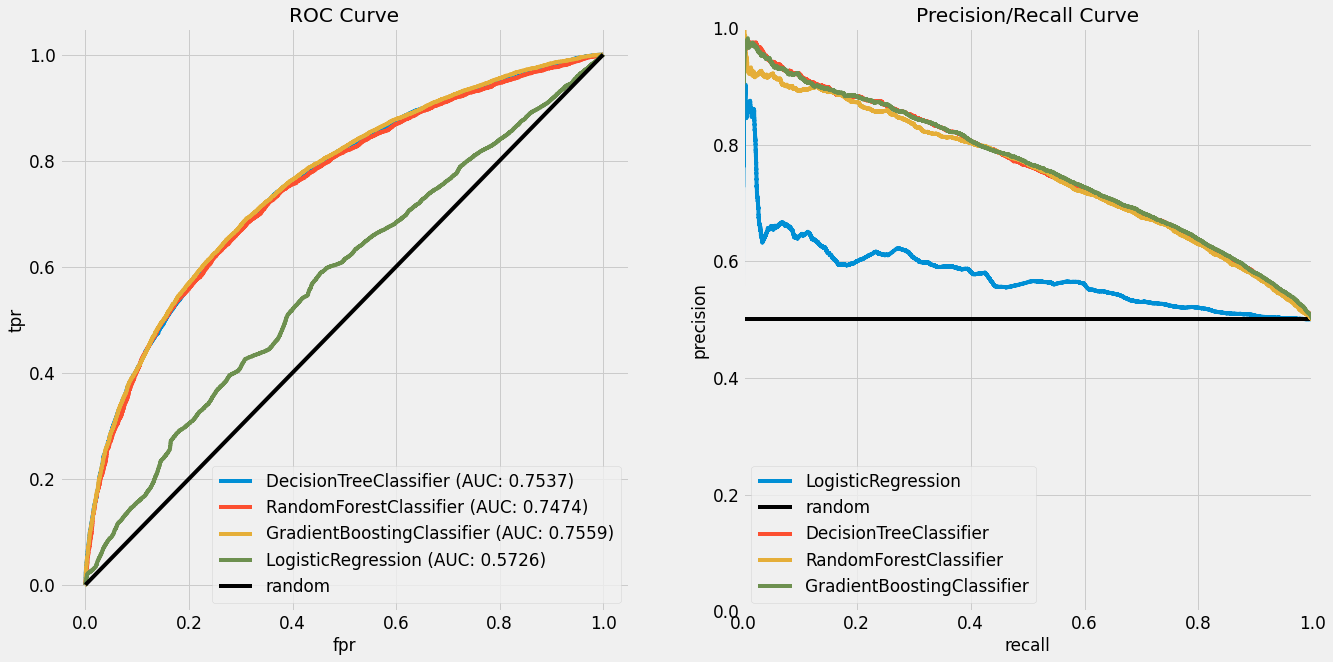

In [599]:
#ROC Curve
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)
plot_roc(ax1, log_reg_df,log_reg,True)

plot_precision_recall(ax2, log_reg_df,log_reg,True)
plot_precision_recall(ax2, dt_df,dt_model)
plot_precision_recall(ax2, rf_df,rf_model)
plot_precision_recall(ax2, gb_df,gb_model)

Text(0.5, 1.0, 'Confusion Matrix with Optimal Threshold')

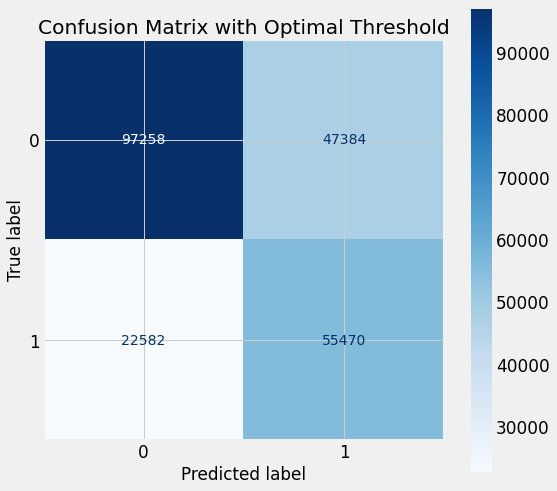

In [365]:
cm = confusion_matrix1(gb_model, X,y, 0.32)

fig, ax = plt.subplots(figsize = (8,8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy())
disp.plot(cmap = plt.cm.Blues, ax = ax)
ax.set_title('Confusion Matrix with Optimal Threshold')

# EDA

In [ ]:
ax = df.groupby(['Division'])['T_No'].mean().plot.bar()
for p in ax.patches:
    ax.annotate((round(p.get_height(),3)), (p.get_x()+p.get_width()/3., p.get_height()*1.005),fontsize='large')
ax.set_title('Average Number of Playweeks by Division')

In [ ]:
def plot_hist_mean(grouped,target,bins=10):
    plot = df.groupby(grouped)[target].mean()
    fig,ax = plt.subplots()
    ax.hist(avg_bo,bins=bins); 

In [ ]:
plot_hist_mean('Division','Boxoffice',bins=50)

In [ ]:
avg_bo = df.groupby('City')['Boxoffice'].mean()
fig,ax = plt.subplots()
ax.hist(avg_bo,bins=10);


In [ ]:
avg_bo_adm = df.groupby('Theatre')[['Boxoffice','Admissions']].mean().sort_values(by='Boxoffice',ascending=False)
avg_bo_adm

In [ ]:
fig,ax = plt.subplots()
%time ax.scatter(avg_bo_adm.Admissions, avg_bo_adm.Boxoffice, alpha=0.5)
ax.set_title('Distribution of Avg Theatre Boxoffice')
ax.set_xlim(0,4000)
ax.set_ylabel('Average Boxoffice')
ax.set_xlabel('Average Admissions')
fig.tight_layout()

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=False).head(10)

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=True).head(10)

In [ ]:
df.groupby('Release')['Boxoffice'].mean().sort_values(ascending=True).tail(10).plot.barh(figsize=(10,7))
plt.xlabel('Average Location Gross')
plt.title('Top 10 Films by Avg Loc Gross')

# Clustering Data

In [96]:
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [255]:
mc.head(2)

,budget,runtime,month,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,history,horror,music,mystery,romance,science,thriller,war
title,,,,,,,,,,,,,,,,,,,,,
CHIPS (2017),25000000,100,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"LEGO BATMAN MOVIE, THE",80000000,104,2,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [998]:
def plot_elbow_sil(df,maxk):
    maxk = maxk
    wcss = []
    sil_scores = []
    for i in tqdm(range(2, maxk)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
        kmeans.fit(df)
        ypred=kmeans.predict(df)
        wcss.append(kmeans.inertia_)    
        labels = kmeans.labels_
        
        score = silhouette_score(df, labels, metric = 'euclidean')
        sil_scores.append(score)
    plt.plot(range(2, maxk), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot Plots
    fig, ax = plt.subplots(figsize=(maxk,10))
    ax.plot(range(2,maxk), sil_scores, 'o-')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette score")

In [ ]:
scale = StandardScaler()
scaled_budget = theat['perc_of_bo']
#transform = scale.fit_transform(percent.values.reshape(-1,1))
#test_full['perc_of_bo'] = transform

In [995]:
# this does not run for some reason???
plot_elbow_sil(theatre_df,50)

KeyboardInterrupt: 

In [846]:
ow_bo

,Release,Boxoffice_Total
0,12 STRONG,19892950
1,"15:17 TO PARIS, THE",17744384
2,ANNABELLE COMES HOME,39301786
3,ANNABELLE: CREATION,45340847
4,AQUAMAN (2018),119892164
...,...,...
49,TAG (2018),22798241
50,TEEN TITANS GO! TO THE MOVIES,16205368
51,TOMB RAIDER,27926483
52,UNFORGETTABLE,6497468


In [256]:
with pd.option_context("display.max_rows", 1000):
    display(mc)

,budget,runtime,month,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,history,horror,music,mystery,romance,science,thriller,war
title,,,,,,,,,,,,,,,,,,,,,
CHIPS (2017),25000000,100,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"LEGO BATMAN MOVIE, THE",80000000,104,2,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
FIST FIGHT,22000000,91,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UNFORGETTABLE,12000000,100,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
KONG: SKULL ISLAND,185000000,118,3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
GOING IN STYLE (2017),25000000,96,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
KING ARTHUR: LEGEND OF THE SWORD,175000000,126,5,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
"EVERYTHING, EVERYTHING",10000000,96,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
WONDER WOMAN,149000000,141,5,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [449]:
full_movie.head(1)

,title,budget,runtime,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT
0,CHIPS (2017),25000000,100,1,0,0,0,0,0,1,0,1,1,0,0,1.091


In [851]:
mc_2 = full_movie.copy()
mc_2 = mc_2.merge(ow_bo,how='left',right_on='Release',left_on='title')
mc_2['ow_by_budget'] = mc_2['Boxoffice_Total']/mc_2['budget']
mc_2['ow_by_runtime'] = mc_2['Boxoffice_Total']/mc_2['runtime']
mc_2.drop(['runtime','budget','Boxoffice_Total','Release'],axis=1,inplace=True)
#mc_2.set_index('title',inplace=True)
mc_2

,title,month,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT,ow_by_budget,ow_by_runtime
0,CHIPS (2017),1,0,0,0,0,0,1,0,1,1,0,0,1.091,0.418685,1.046713e+05
1,"LEGO BATMAN MOVIE, THE",2,0,0,0,0,0,1,1,1,0,1,0,1.697,0.709918,5.460906e+05
2,FIST FIGHT,2,0,0,0,0,0,0,0,1,0,0,0,1.361,0.762705,1.843902e+05
3,UNFORGETTABLE,3,0,1,0,0,0,0,0,0,1,0,0,0.888,0.541456,6.497468e+04
4,KONG: SKULL ISLAND,3,0,0,0,0,0,1,0,0,0,1,0,1.728,0.394230,6.180724e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,JOKER,10,0,1,0,0,0,0,0,0,1,0,0,0.852,2.249644,1.014184e+06
48,DOCTOR SLEEP (2019),10,0,1,1,0,0,0,0,0,1,1,0,0.758,0.380744,1.127202e+05
49,MOTHERLESS BROOKLYN,10,0,1,0,0,0,0,0,0,1,0,0,0.512,0.198681,3.562548e+04
50,"GOOD LIAR, THE",11,0,1,0,0,1,0,0,0,1,0,0,0.513,0.846804,7.768846e+04


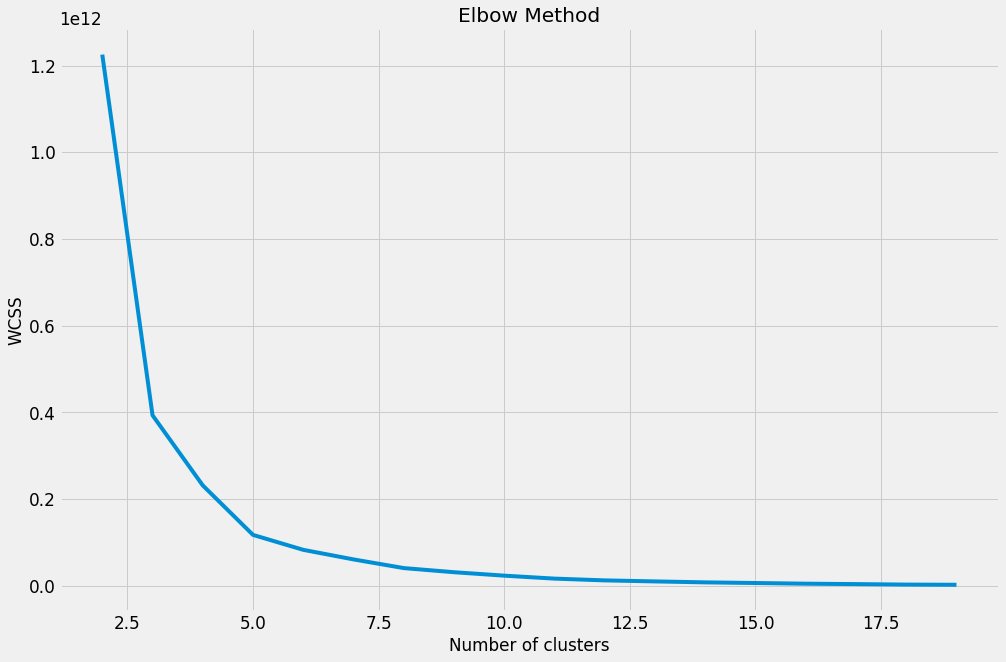

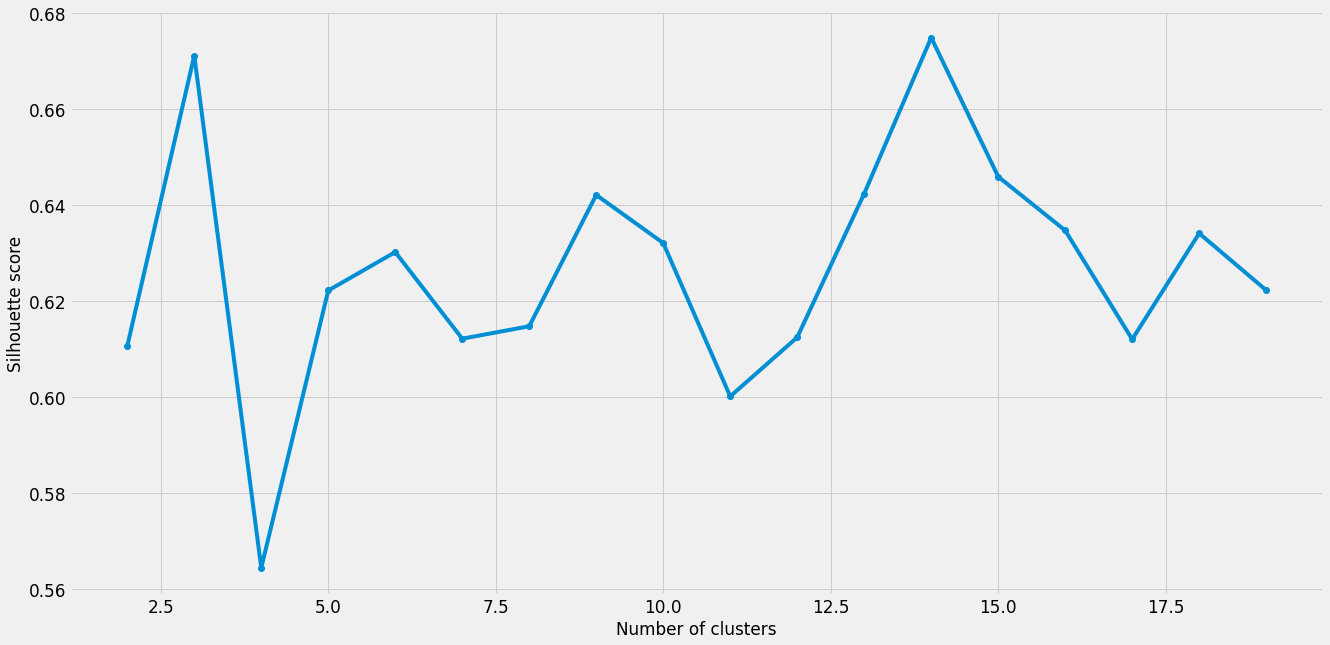

In [460]:
# Is this enough clustering to reduce dimensionality within the movie table?
plot_elbow_sil(mc_2,20)

In [461]:
#Movie Clustering
mc_cluster = KMeans(n_clusters=14, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = mc_cluster.fit_predict(mc_2)
mc_2['clusters']=pred_y

In [462]:
cluster_test = mc_2['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

title
RICHARD JEWELL                         0
GOOD LIAR, THE                         0
KITCHEN, THE                           0
BLINDED BY THE LIGHT (2083623)         0
FATHER FIGURES                         0
UNFORGETTABLE                          0
IT CHAPTER TWO                         1
NUN, THE                               1
POKEMON DETECTIVE PIKACHU              1
LEGO BATMAN MOVIE, THE                 1
DUNKIRK (2017)                         1
KONG: SKULL ISLAND                     1
JUSTICE LEAGUE (2017)                  2
JOKER                                  2
WONDER WOMAN                           2
CRAZY RICH ASIANS                      3
ANNABELLE: CREATION                    3
READY PLAYER ONE                       3
GODZILLA: KING OF THE MONSTERS         3
TAG (2018)                             4
LEGO NINJAGO MOVIE, THE                4
MULE, THE                              4
GAME NIGHT                             4
TOMB RAIDER                            4
BLADE RUNN

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(avg_bo_adm)
plt.scatter(avg_bo_adm.Admissions, avg_bo_adm.Boxoffice,alpha=0.9)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=300, c='tab:red',alpha=0.7)
plt.title('K-Means Clustering: 3')
plt.ylabel('Boxoffice')
plt.xlabel('Admissions')
plt.xlim(0,4000)
plt.show()

In [ ]:
import matplotlib.colors as mcols

# define a colormap using a list of custom colors
cmap = mcols.ListedColormap(['tab:blue','tab:purple','tab:green','tab:red','tab:orange','tab:olive','tab:cyan'])

kmeans = KMeans(3,random_state=0).fit_predict(avg_bo_adm)
plt.scatter(avg_bo_adm.Admissions, avg_bo_adm.Boxoffice,c=kmeans,s=50,cmap=cmap,alpha=0.9)
#plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=100, c='red',alpha=0.5)

plt.title('K-Means Clustering: 3')
plt.ylabel('Boxoffice')
plt.xlabel('Admissions')
plt.xlim(0,4000)
plt.show()

# NLP on Plot Overview

In [726]:
import string
import unicodedata

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser



def extract_bow_from_raw_text(text_as_string):
    """Extracts bag-of-words from a raw text string.

    Parameters
    ----------
    text (str): a text document given as a string

    Returns
    -------
    list : the list of the tokens extracted and filtered from the text
    """
    if (text_as_string == None):
        return []

    if (len(text_as_string) < 1):
        return []

    nfkd_form = unicodedata.normalize('NFKD', text_as_string)
    text_input = str(nfkd_form.encode('ASCII', 'ignore'))

    sent_tokens = sent_tokenize(text_input)

    tokens = list(map(word_tokenize, sent_tokens))

    sent_tags = list(map(pos_tag, tokens))

    grammar = r"""
        SENT: {<(J|N).*>}                # chunk sequences of proper nouns
    """

    cp = RegexpParser(grammar)
    ret_tokens = list()
    #lemmatizer = WordNetLemmatizer()
    stemmer_snowball = SnowballStemmer('english')

    for sent in sent_tags:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'SENT':
                t_tokenlist = [tpos[0].lower() for tpos in subtree.leaves()]
                #t_tokens_lemma = list(map(lemmatizer.lemmatize, t_tokenlist))
                t_tokens_stemsnowball = list(map(stemmer_snowball.stem, t_tokenlist))
    
                ret_tokens.extend(t_tokens_stemsnowball)

    return(ret_tokens)
    

In [723]:
movies.overview

0     The adventures of two California Highway Patro...
1     A cooler-than-ever Bruce Wayne must deal with ...
2     When one school teacher gets the other fired, ...
3     Julia moves in with her fiancé, David, but his...
4     Explore the mysterious and dangerous home of t...
                            ...                        
50    During the 1980s, a failed stand-up comedian i...
51    Still irrevocably scarred by the trauma he end...
52    New York City, 1957. Lionel Essrog, a private ...
53    Career con man Roy sets his sights on his late...
54    Richard Jewell thinks quick, works fast, and s...
Name: overview, Length: 54, dtype: object

In [714]:
docs = []
for desc in movies.overview:
    docs.append(desc)

In [727]:
# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row), docs))

In [728]:
# displaying bows
for i in range(len(docs)):
    print("\n--- Plot: {}".format(docs[i]))
    print("--- BoW: {}".format(bows[i]))


--- Plot: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- BoW: ["b'the", 'adventur', 'california', 'highway', 'patrol', 'motorcycl', 'offic', 'round', 'freeway', 'los', 'angel']

--- Plot: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wishes to become his sidekick.
--- BoW: ['b', 'cooler-than-ev', 'bruce', 'wayn', 'usual', 'suspect', 'gotham', 'citi', 'teenag', 'orphan', 'sidekick']

--- Plot: When one school teacher gets the other fired, he is challenged to an after-school fight.
--- BoW: ["b'when", 'school', 'other', 'after-school', 'fight']

--- Plot: Julia moves in with her fiancé, David, but his ex-wife and her own haunting past join forces to rock her quiet suburban existence.
--- BoW: ["b'julia", 'move', 'fianc', 'david', 'ex-wif', 'own', 'haunt', 'join', 'forc', 'quiet', 's

In [303]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), bows))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(bows[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- term_occ: {}".format(term_occ[i]))
    print("--- term_freq: {}".format(term_freq[i]))


--- review: The adventures of two California Highway Patrol motorcycle officers as they make their rounds on the freeways of Los Angeles.
--- bow: ["b'the", 'adventure', 'california', 'highway', 'patrol', 'motorcycle', 'officer', 'round', 'freeway', 'los', 'angeles']
--- term_occ: Counter({"b'the": 1, 'adventure': 1, 'california': 1, 'highway': 1, 'patrol': 1, 'motorcycle': 1, 'officer': 1, 'round': 1, 'freeway': 1, 'los': 1, 'angeles': 1})
--- term_freq: {"b'the": 0.09090909090909091, 'adventure': 0.09090909090909091, 'california': 0.09090909090909091, 'highway': 0.09090909090909091, 'patrol': 0.09090909090909091, 'motorcycle': 0.09090909090909091, 'officer': 0.09090909090909091, 'round': 0.09090909090909091, 'freeway': 0.09090909090909091, 'los': 0.09090909090909091, 'angeles': 0.09090909090909091}

--- review: A cooler-than-ever Bruce Wayne must deal with the usual suspects as they plan to rule Gotham City, while discovering that he has accidentally adopted a teenage orphan who wis

In [305]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(docs)))
            for k, v in doc_occ.items()}

# displaying vocabulary
print("\n--- full vocabulary: {}".format(doc_occ))
print("\n--- doc freq: {}".format(doc_freq))


--- full vocabulary: Counter({'b': 24, 'life': 9, 'friend': 9, 'own': 8, 'world': 7, 'new': 7, 'everything': 6, 'year': 6, 'city': 5, 'force': 5, 'home': 5, 'boy': 5, 'team': 4, 'child': 4, 'first': 4, 'daughter': 4, 'monster': 4, 'young': 4, 'york': 4, 'family': 4, 'bruce': 3, "b'when": 3, 'other': 3, 'school': 3, 'king': 3, 'island': 3, 'father': 3, 'stone': 3, 'arthur': 3, 'way': 3, 'teenager': 3, 'man': 3, 'college': 3, 'dream': 3, 'night': 3, 'day': 3, 'series': 3, 'earth': 3, 'threat': 3, 'mother': 3, 'brother': 3, 'agent': 3, 'people': 3, 'member': 3, 'game': 3, 'head': 3, 'best': 3, 'living': 3, 'crime': 3, 'officer': 2, "b'the": 2, 'gotham': 2, 'sidekick': 2, 'wayne': 2, 'suburban': 2, 'existence': 2, 'ape': 2, 'deep': 2, 'money': 2, 'pal': 2, 'idea': 2, 'true': 2, 'door': 2, 'evil': 2, 'human': 2, 'war': 2, 'help': 2, 'major': 2, 'need': 2, 'army': 2, 'britain': 2, 'little': 2, 'several': 2, 'nun': 2, 'target': 2, 'doll': 2, 'death': 2, 'maine': 2, 'pennywise': 2, 'club': 2,

In [1030]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.04

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),sorted(vocabulary)))

-- vocabulary (len=49): ['agent', 'arthur', 'b', "b'when", 'best', 'boy', 'brother', 'bruce', 'child', 'city', 'college', 'crime', 'daughter', 'day', 'dream', 'earth', 'everything', 'family', 'father', 'first', 'force', 'friend', 'game', 'head', 'home', 'island', 'king', 'life', 'living', 'man', 'member', 'monster', 'mother', 'new', 'night', 'other', 'own', 'people', 'school', 'series', 'stone', 'team', 'teenager', 'threat', 'way', 'world', 'year', 'york', 'young']


In [1032]:
import numpy as np

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(docs),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
'''for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))
         '''

'for i in range(len(docs)):\n    print("\n--- review: {}".format(docs[i]))\n    print("--- bow: {}".format(bows[i]))\n    print("--- tfidf vector: {}".format( vectors[i] ) )\n    print("--- tfidf sorted: {}".format( \n            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )\n         ))\n         '

In [1033]:
mv_tf_idf2 = pd.DataFrame(data=vectors,columns=sorted(vocabulary))
mv_tf_idf2 = mv_tf_idf2.rename(columns={"b'in":'in',"b'the":'the',"b'when":'when'})
mv_tf_idf2.drop('b',axis=1,inplace=True)

mv_tf_idf2

,agent,arthur,when,best,boy,brother,bruce,child,city,college,crime,daughter,day,dream,earth,everything,family,father,first,force,friend,game,head,home,island,king,life,living,man,member,monster,mother,new,night,other,own,people,school,series,stone,team,teenager,threat,way,world,year,york,young
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,0.224373,0.107150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.588888,0.588888,0.588888,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.170641,0.205675,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205675,0.24537,0.24537,0.222846,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.189854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.149685,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.452991
50,0.000000,0.045333,0.000000,0.000000,0.000000,0.078757,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.102852,0.0,0.0,0.0,0.0,0.0,0.113248,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
51,0.123405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.097296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133707,0.147222,0.147222,0.0,0.000000
52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.184027,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


# Sklearn TFIDF

In [753]:
corpus = [row for row in docs]
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(stop_words='english')

document_tf_matrix = tf.fit_transform(corpus).todense()

sorted(tf.vocabulary_);
document_tf_matrix;

from math import log

def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
sorted(tf.vocabulary_);
idf(document_tf_matrix);

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
document_tfidf_matrix = tfidf.fit_transform(corpus)
#print(tfidf.vocabulary_)
print(document_tfidf_matrix.todense())

# PCA

In [1034]:
from sklearn.decomposition import PCA
mv_tf_idf2_std = (mv_tf_idf2-np.mean(mv_tf_idf2))/np.std(mv_tf_idf2)
n_components = 2


In [1035]:
#mv_tf_idf2_std = mv_tf_idf2_std.fillna(0)

In [1036]:
mv_tf2_pca = PCA(n_components=n_components).fit_transform(mv_tf_idf2_std.values)
#mv_tf_pca = movies_tfidf_std.values @ pca.components_.T
mv_tf2_pca

array([[ 0.11963613,  0.31780658],
       [-0.65478633, -0.6408721 ],
       [ 2.01122269,  9.29620361],
       [-0.62163647,  0.46410931],
       [ 5.46323717, -0.20084787],
       [ 0.11963613,  0.31780658],
       [ 2.42744454, -4.96076511],
       [-3.56429642, -1.32047249],
       [ 0.67128564,  0.99695677],
       [ 0.30424571,  1.54810727],
       [ 0.16238521,  0.33626295],
       [ 0.88426937, -0.18794801],
       [-0.89271971, -0.30217088],
       [ 0.90329856,  1.64462489],
       [-0.04488308, -0.22879375],
       [ 0.24761097, -1.25948342],
       [-0.22532914,  0.39347515],
       [ 2.10667178, -3.05150595],
       [ 4.25495593, -3.2404511 ],
       [ 1.39340617, -0.1821917 ],
       [ 0.54503748,  1.46534056],
       [ 0.57077645,  0.75090072],
       [ 4.11706262,  0.07007215],
       [ 0.29833946,  0.54533934],
       [ 0.79252478, -0.02564159],
       [ 0.96665133,  2.35391283],
       [ 0.62858576,  0.4547695 ],
       [-1.46214561, -0.5282122 ],
       [-0.89002342,

Text(0, 0.5, 'Second Principal Component')

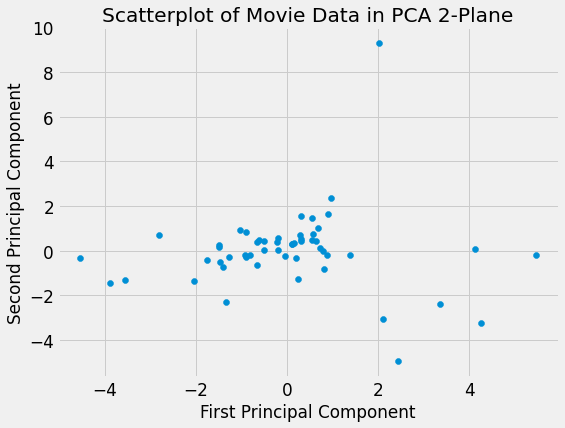

In [1037]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(mv_tf2_pca[:, 0], mv_tf2_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

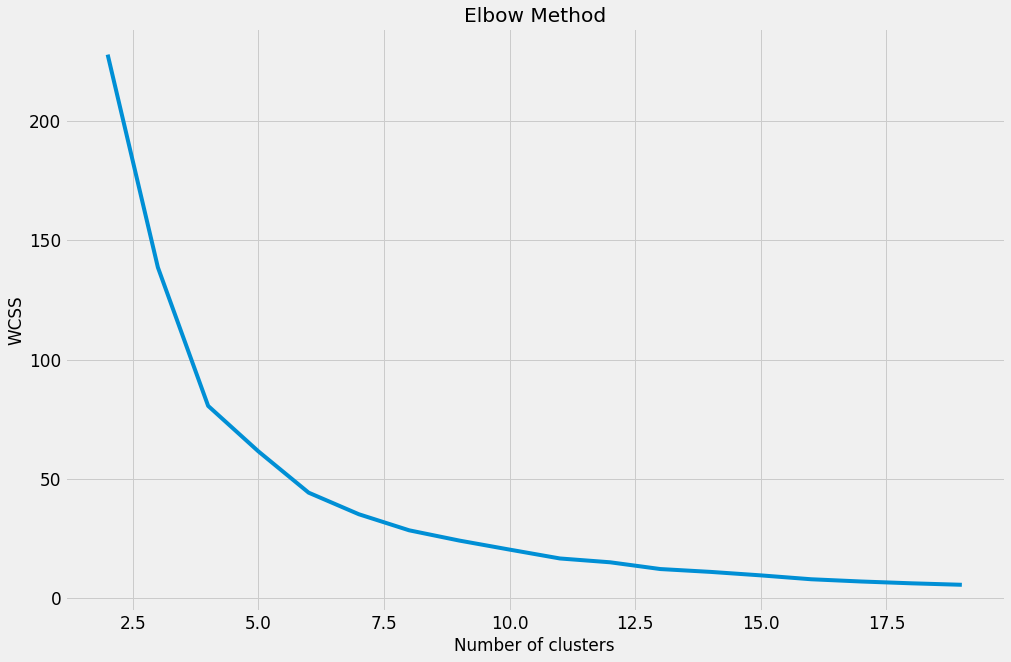

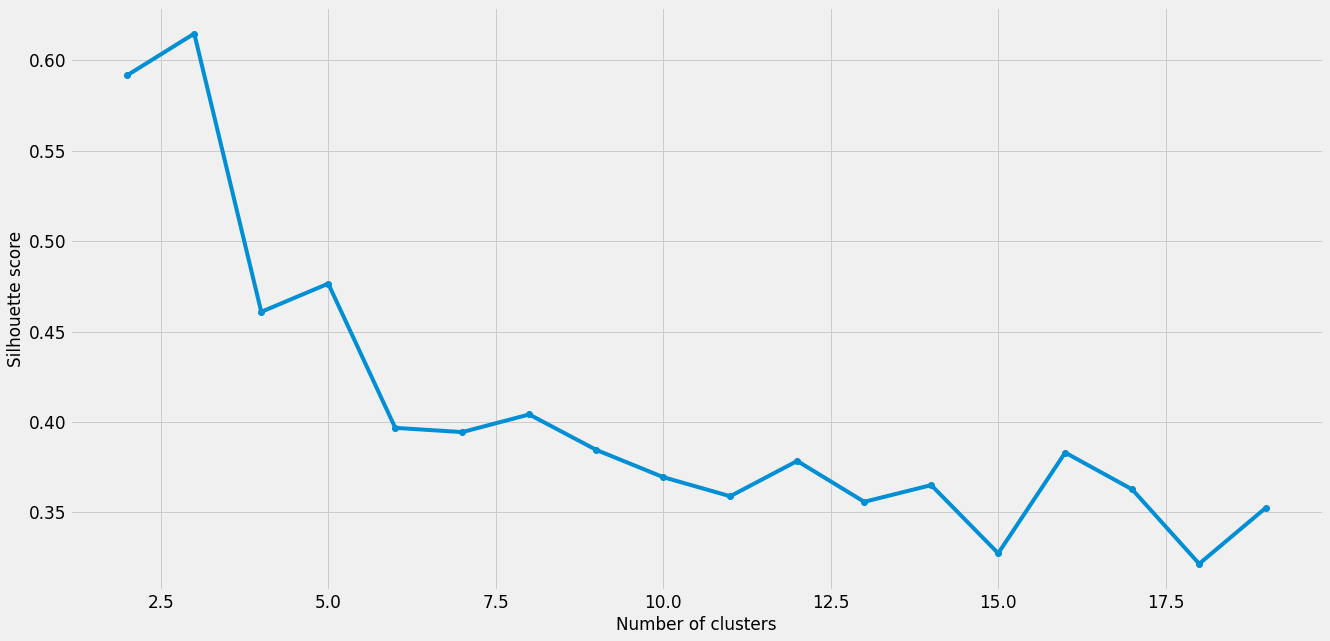

In [1038]:
plot_elbow_sil(mv_tf2_pca,20)

In [1039]:
#Movie Clustering
pca_cluster = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = pca_cluster.fit_predict(mv_tf2_pca)

mv_pca = pd.DataFrame(mv_tf2_pca, columns = ('PCA1','PCA2'))
mv_pca = mv_pca.join(mc_2['title'],how='left')
mv_pca.set_index('title',inplace=True)
mv_pca['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca['clusters']

with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

title
CHIPS (2017)                          0
CRAZY RICH ASIANS                     0
NUN, THE                              0
SMALLFOOT                             0
STAR IS BORN, A (2024779)             0
AQUAMAN (2018)                        0
MULE, THE                             0
ISN'T IT ROMANTIC                     0
SHAZAM! (2019)                        0
CURSE OF LA LLORONA, THE              0
POKEMON DETECTIVE PIKACHU             0
SUN IS ALSO A STAR, THE               0
GODZILLA: KING OF THE MONSTERS        0
SHAFT (2074539)                       0
ANNABELLE COMES HOME                  0
KITCHEN, THE                          0
BLINDED BY THE LIGHT (2083623)        0
IT CHAPTER TWO                        0
GOLDFINCH, THE                        0
JOKER                                 0
DOCTOR SLEEP (2019)                   0
MOTHERLESS BROOKLYN                   0
GOOD LIAR, THE                        0
RICHARD JEWELL                        0
MEG, THE                          

In [980]:
mv_pca_full = pd.DataFrame(mv_tf2_pca, columns = ('PCA1','PCA2'))
mv_pca_full = mv_pca_full.join(mc_2,how='right')
mv_pca_full.set_index('title',inplace=True)
mv_pca_full.drop(['month'],axis=1,inplace=True)

#scale = StandardScaler()
#runtime = mv_pca_full['ow_by_runtime']
#transform = scale.fit_transform(runtime.values.reshape(-1,1))
#mv_pca_full['ow_by_runtime']= transform

mv_pca_full

,PCA1,PCA2,documentary,drama,horror,music,mystery,act/adv,ani/fam,rom/com,crime_thriler,sci-fi/fan,old_war,OW to YT,ow_by_budget,ow_by_runtime
title,,,,,,,,,,,,,,,,
CHIPS (2017),0.119636,0.317807,0,0,0,0,0,1,0,1,1,0,0,1.091,0.418685,1.046713e+05
"LEGO BATMAN MOVIE, THE",-0.654786,-0.640872,0,0,0,0,0,1,1,1,0,1,0,1.697,0.709918,5.460906e+05
FIST FIGHT,2.011223,9.296204,0,0,0,0,0,0,0,1,0,0,0,1.361,0.762705,1.843902e+05
UNFORGETTABLE,-0.621636,0.464109,0,1,0,0,0,0,0,0,1,0,0,0.888,0.541456,6.497468e+04
KONG: SKULL ISLAND,5.463237,-0.200848,0,0,0,0,0,1,0,0,0,1,0,1.728,0.394230,6.180724e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JOKER,0.204869,-0.336895,0,1,0,0,0,0,0,0,1,0,0,0.852,2.249644,1.014184e+06
DOCTOR SLEEP (2019),-2.036278,-1.352353,0,1,1,0,0,0,0,0,1,1,0,0.758,0.380744,1.127202e+05
MOTHERLESS BROOKLYN,-1.401615,-0.743247,0,1,0,0,0,0,0,0,1,0,0,0.512,0.198681,3.562548e+04


In [981]:
mv_pca_full=mv_pca_full.drop(mv_pca_full.columns[2:13],axis=1)
#mv_pca_full=mv_pca_full.drop('clusters',axis=1)

In [982]:
mv_pca_full

,PCA1,PCA2,OW to YT,ow_by_budget,ow_by_runtime
title,,,,,
CHIPS (2017),0.119636,0.317807,1.091,0.418685,1.046713e+05
"LEGO BATMAN MOVIE, THE",-0.654786,-0.640872,1.697,0.709918,5.460906e+05
FIST FIGHT,2.011223,9.296204,1.361,0.762705,1.843902e+05
UNFORGETTABLE,-0.621636,0.464109,0.888,0.541456,6.497468e+04
KONG: SKULL ISLAND,5.463237,-0.200848,1.728,0.394230,6.180724e+05
...,...,...,...,...,...
JOKER,0.204869,-0.336895,0.852,2.249644,1.014184e+06
DOCTOR SLEEP (2019),-2.036278,-1.352353,0.758,0.380744,1.127202e+05
MOTHERLESS BROOKLYN,-1.401615,-0.743247,0.512,0.198681,3.562548e+04


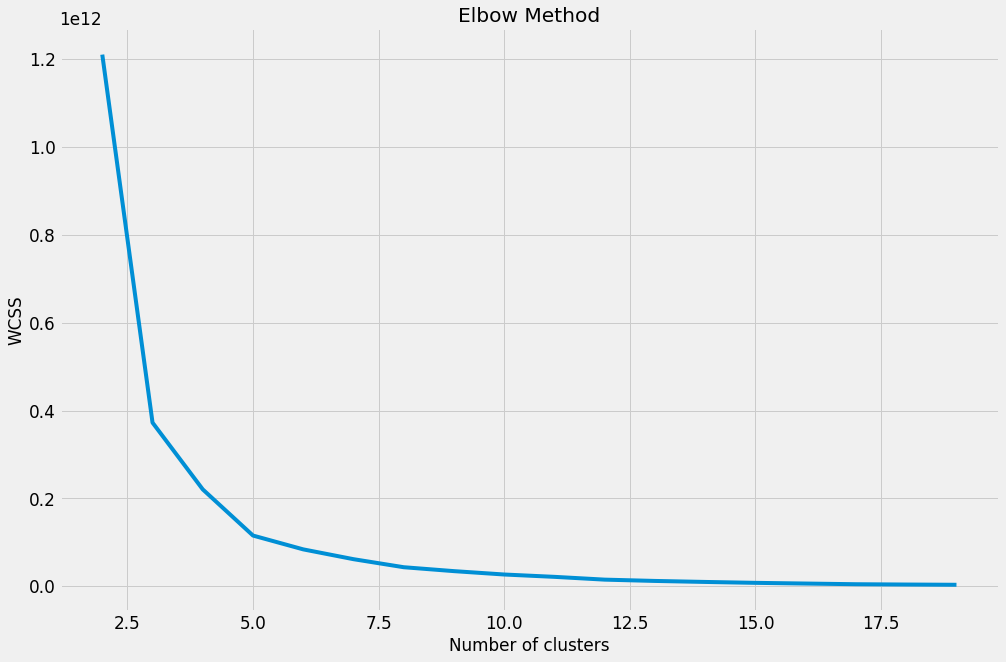

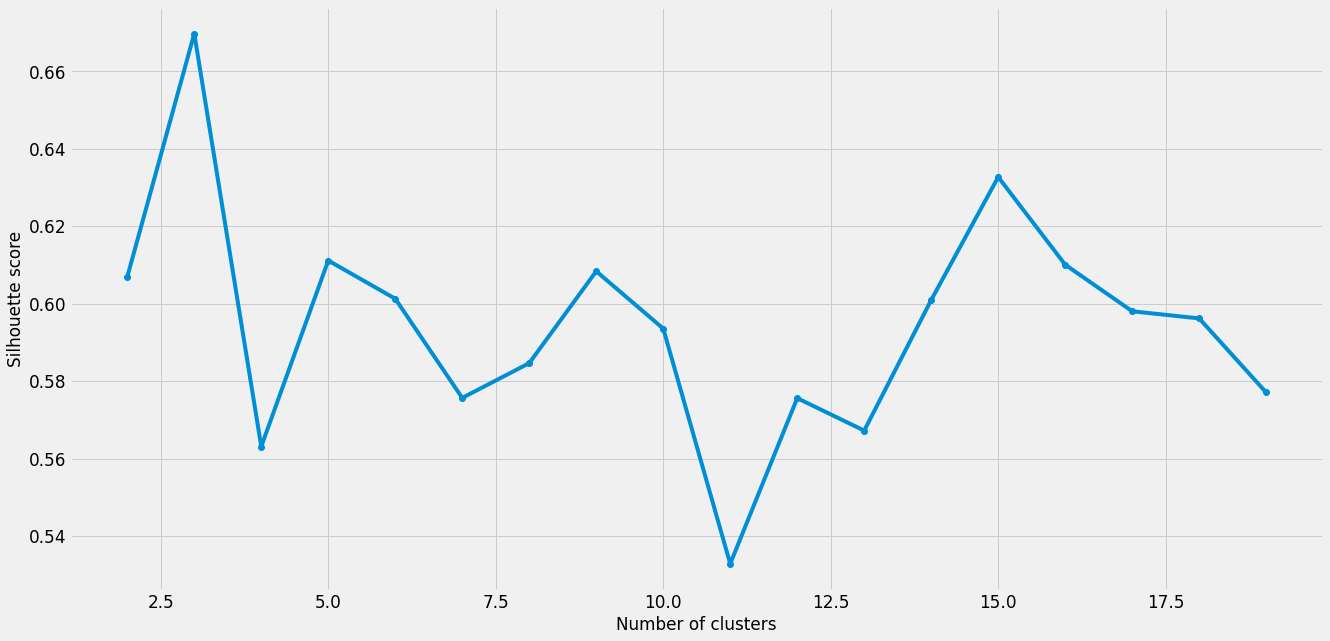

In [983]:
plot_elbow_sil(mv_pca_full,20)

In [986]:
#Movie Clustering
tfidf_cluster = KMeans(n_clusters=15, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = tfidf_cluster.fit_predict(mv_pca_full)
mv_pca_full['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

title
IT CHAPTER TWO                         0
POKEMON DETECTIVE PIKACHU              0
NUN, THE                               0
KONG: SKULL ISLAND                     0
DUNKIRK (2017)                         0
FIST FIGHT                             1
GOING IN STYLE (2017)                  1
15:17 TO PARIS, THE                    1
TEEN TITANS GO! TO THE MOVIES          1
JOKER                                  2
WONDER WOMAN                           2
JUSTICE LEAGUE (2017)                  2
CRAZY RICH ASIANS                      3
ANNABELLE: CREATION                    3
GODZILLA: KING OF THE MONSTERS         3
GOOD LIAR, THE                         4
BLINDED BY THE LIGHT (2083623)         4
KITCHEN, THE                           4
RICHARD JEWELL                         4
UNFORGETTABLE                          4
FATHER FIGURES                         4
LEGO BATMAN MOVIE, THE                 5
STAR IS BORN, A (2024779)              5
MULE, THE                              6
LEGO NINJA